<a href="https://colab.research.google.com/github/Ermi1223/SSM-Time-Series-Prediction/blob/main/SSM_Time_Series_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1: Install Libraries & Import Dependencies**

In [1]:
!pip install numpy pandas torch matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

**Step 2: Load and Preprocess Data**

**2.1 Load Sample Data (Daily Temperature Dataset)**

In [10]:
# Example: Load a temperature dataset from a URL
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
data = pd.read_csv(url, parse_dates=['Date'], index_col='Date')
print(data.head())

            Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8


**2.2 Handle Missing Values & Normalize**

In [11]:
# Fill missing values (if any)
data = data.ffill().bfill()

# Normalize to [0, 1]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.values).flatten()

**2.3 Split into Sequences**

In [12]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 30  # Use 30 days to predict the next day
X, y = create_sequences(scaled_data, seq_length)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

**2.4 Convert to PyTorch Tensors**

In [13]:
X_train = torch.FloatTensor(X_train).unsqueeze(-1)  # Shape: (samples, seq_len, 1)
y_train = torch.FloatTensor(y_train).unsqueeze(-1)
X_test = torch.FloatTensor(X_test).unsqueeze(-1)
y_test = torch.FloatTensor(y_test).unsqueeze(-1)

**Step 3: Define SSM Model (PyTorch)**

In [16]:
class SSM(nn.Module):
    def __init__(self, state_dim=4, input_dim=1, output_dim=1):
        super().__init__()
        self.A = nn.Parameter(torch.randn(state_dim, state_dim) * 0.01)
        self.B = nn.Parameter(torch.randn(state_dim, input_dim) * 0.01)
        self.C = nn.Parameter(torch.randn(output_dim, state_dim) * 0.01)
        self.D = nn.Parameter(torch.randn(output_dim, input_dim) * 0.01)

    def forward(self, u_seq):
        batch_size, seq_len, _ = u_seq.shape
        x = torch.zeros(batch_size, self.A.shape[0]).to(u_seq.device)
        outputs = []
        for t in range(seq_len):
            u_t = u_seq[:, t, :]
            x = torch.matmul(x, self.A) + torch.matmul(u_t, self.B.T)
            y_t = torch.matmul(x, self.C.T) + torch.matmul(u_t, self.D.T)
            outputs.append(y_t)
        return torch.stack(outputs, dim=1)


**Step 4: Train the SSM**

In [17]:
# Hyperparameters
EPOCHS = 50
LR = 0.001
BATCH_SIZE = 32

# Initialize model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SSM().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Training loop
for epoch in range(EPOCHS):
    model.train()
    for i in range(0, len(X_train), BATCH_SIZE):
        batch_X = X_train[i:i+BATCH_SIZE].to(device)
        batch_y = y_train[i:i+BATCH_SIZE].to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs[:, -1, :], batch_y)  # Predict last step
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.4f}")

Epoch 1/50, Loss: 0.2176
Epoch 2/50, Loss: 0.0158
Epoch 3/50, Loss: 0.0137
Epoch 4/50, Loss: 0.0136
Epoch 5/50, Loss: 0.0136
Epoch 6/50, Loss: 0.0136
Epoch 7/50, Loss: 0.0136
Epoch 8/50, Loss: 0.0135
Epoch 9/50, Loss: 0.0135
Epoch 10/50, Loss: 0.0135
Epoch 11/50, Loss: 0.0135
Epoch 12/50, Loss: 0.0135
Epoch 13/50, Loss: 0.0134
Epoch 14/50, Loss: 0.0134
Epoch 15/50, Loss: 0.0134
Epoch 16/50, Loss: 0.0133
Epoch 17/50, Loss: 0.0133
Epoch 18/50, Loss: 0.0133
Epoch 19/50, Loss: 0.0132
Epoch 20/50, Loss: 0.0132
Epoch 21/50, Loss: 0.0132
Epoch 22/50, Loss: 0.0131
Epoch 23/50, Loss: 0.0131
Epoch 24/50, Loss: 0.0131
Epoch 25/50, Loss: 0.0130
Epoch 26/50, Loss: 0.0130
Epoch 27/50, Loss: 0.0129
Epoch 28/50, Loss: 0.0129
Epoch 29/50, Loss: 0.0129
Epoch 30/50, Loss: 0.0128
Epoch 31/50, Loss: 0.0128
Epoch 32/50, Loss: 0.0127
Epoch 33/50, Loss: 0.0127
Epoch 34/50, Loss: 0.0126
Epoch 35/50, Loss: 0.0126
Epoch 36/50, Loss: 0.0125
Epoch 37/50, Loss: 0.0125
Epoch 38/50, Loss: 0.0125
Epoch 39/50, Loss: 0.

**Step 5: LSTM Baseline**

In [20]:
class LSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, output_dim=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.linear(out[:, -1, :])  # Predict last step

# Train the LSTM similarly (same training loop)

**Step 6: Evaluate and Compare**

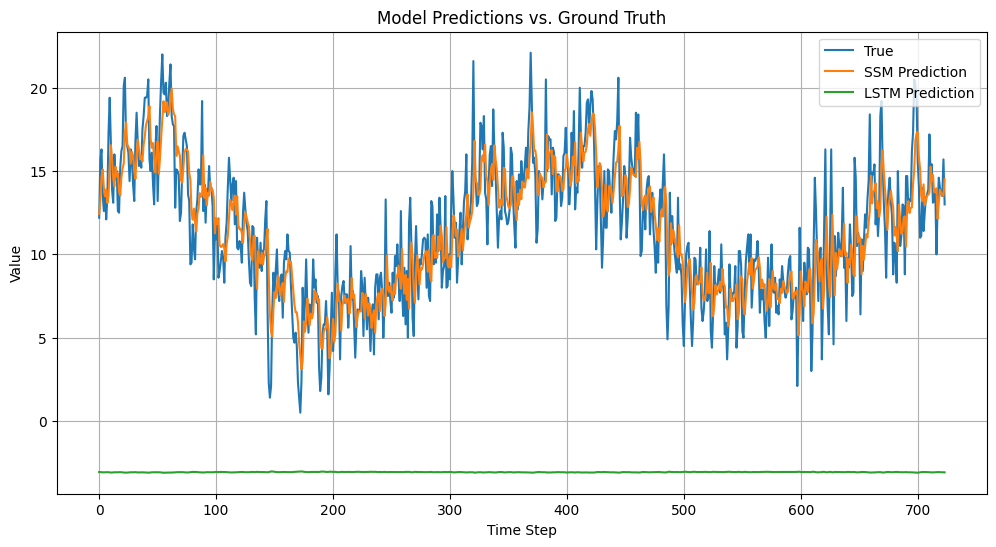

In [21]:
# Instantiate and prepare LSTM model
lstm_model = LSTM(input_dim=1, hidden_dim=64, output_dim=1).to(device)
lstm_model.eval()

# (Optional) Load pretrained weights if available
# lstm_model.load_state_dict(torch.load("lstm_model.pt"))

# Evaluate SSM Model
model.eval()
with torch.no_grad():
    test_pred_ssm = model(X_test.to(device)).cpu().numpy()[:, -1, :]  # assuming model outputs sequence

# Evaluate LSTM Model
with torch.no_grad():
    test_pred_lstm = lstm_model(X_test.to(device)).cpu().numpy()

# Inverse scaling
test_pred_ssm = scaler.inverse_transform(test_pred_ssm)
test_pred_lstm = scaler.inverse_transform(test_pred_lstm)
y_test_actual = scaler.inverse_transform(y_test.numpy())

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="True")
plt.plot(test_pred_ssm, label="SSM Prediction")
plt.plot(test_pred_lstm, label="LSTM Prediction")
plt.legend()
plt.title("Model Predictions vs. Ground Truth")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.grid(True)
plt.show()

**Step 7: Save Models**

In [22]:
# Save SSM
torch.save(model.state_dict(), "ssm_model.pth")

# Save LSTM
torch.save(lstm_model.state_dict(), "lstm_model.pth")